Declarations - always run this before proceeding to diff sections below

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Variables
heart_amplitude = 0.5
heart_frequency = 120 / 60
lung_amplitude = 0.5
lung_frequency = 15 / 60
sampling_rate = 8
sampling_interval = 1 / sampling_rate
motor_speed_rpm = 200
lead_screw_lead = 8
steps_per_revolution = 200

def generate_motion(t, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency):
    heart_motion = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t)
    lung_motion = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t)
    combined_motion = heart_motion + lung_motion
    return heart_motion, lung_motion, combined_motion

def encode_motor_instructions(steps, sampling_rate):
    instructions = ['P', f'{sampling_rate:X}']  # Starting message and sampling rate in single hex byte
    for step in steps:
        sign = '1' if step >= 0 else '0'
        magnitude = f'{abs(step):02X}'
        instructions.append(sign)
        instructions.append(magnitude)
    instructions.append('F')  # Ending byte
    return ''.join(instructions)

Part 1 is initial attempt for wave reconstruction with 20Hz sampling, and see rough estimate of instantaneous velocity of the motor

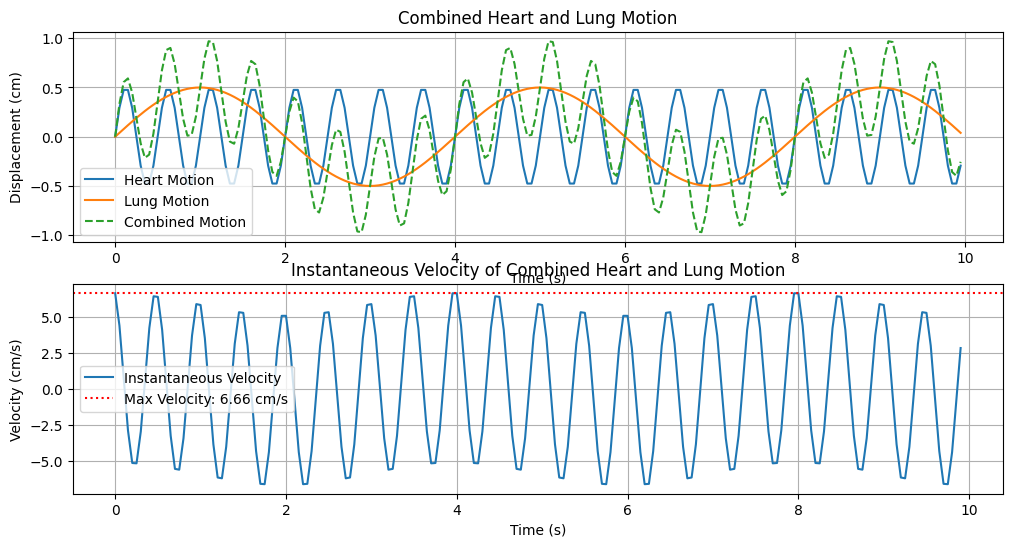

Maximum per-second travel speed required: 6.66 cm/s


In [5]:
# Time array, resol 20Hz
dt = 0.05
t = np.arange(0, 10, dt)

heart_motion, lung_motion, combined_motion = generate_motion(t, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

# Visualization of motion waveforms
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, heart_motion, label='Heart Motion')
plt.plot(t, lung_motion, label='Lung Motion')
plt.plot(t, combined_motion, label='Combined Motion', linestyle='--')
plt.title('Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)

# Visualization of instantaneous velocity
velocity = np.diff(combined_motion) / dt
plt.subplot(2, 1, 2)
plt.plot(t[:-1], velocity, label='Instantaneous Velocity')
max_velocity = np.max(np.abs(velocity))
plt.axhline(max_velocity, color='r', linestyle=':', label=f'Max Velocity: {max_velocity:.2f} cm/s')
plt.title('Instantaneous Velocity of Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.grid(True)

plt.show()

print(f'Maximum per-second travel speed required: {max_velocity:.2f} cm/s')

Part 2: Determine the right sampling rate for wave reconstruction, comparisons, 8Hz seemed pretty reasonable for a first test, later on can add greater accuracy with finer resol

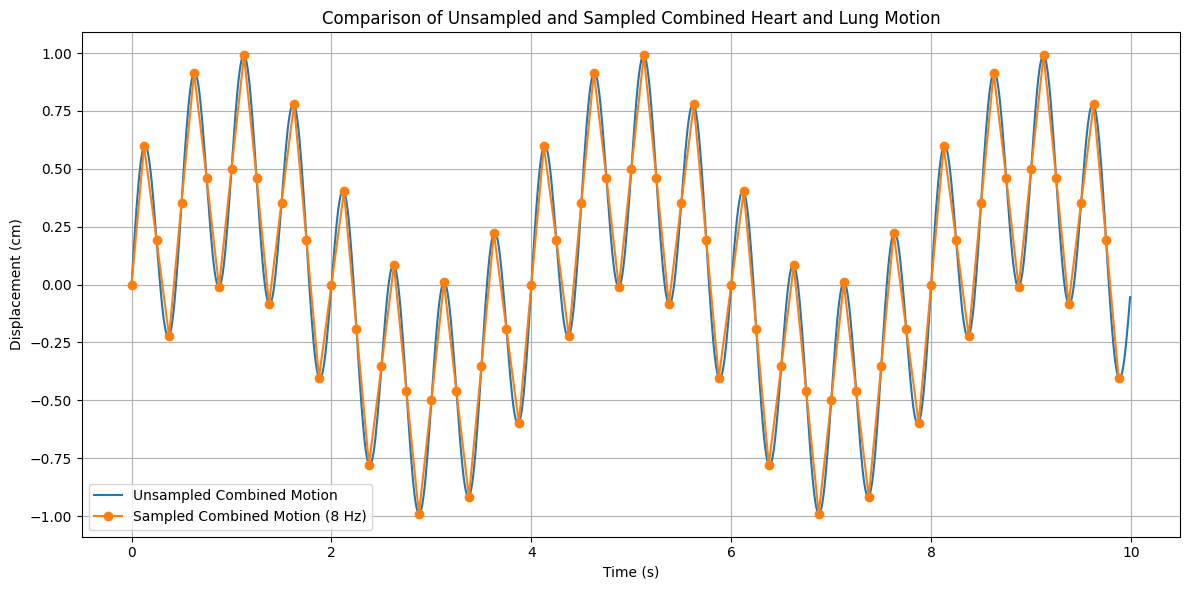

Maximum travel distance between consecutive sampling points: 0.5975451610080658 cm
Speed required: 4.780361288064526 cm


In [6]:
t_fine = np.arange(0, 10, 0.01)
t_sampled = np.arange(0, 10, sampling_interval)

# Unsampled - finer time resolution
heart_motion_fine, lung_motion_fine, combined_motion_fine = generate_motion(t_fine, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

# Sampling
heart_motion_sampled, lung_motion_sampled, combined_motion_sampled = generate_motion(t_sampled, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

# Calculate maximum travel distance between consecutive sampling points
travel_distances = np.abs(np.diff(combined_motion_sampled))  
max_travel_distance = np.max(travel_distances) 

# Plotting
plt.figure(figsize=(12, 6))

# Plot unsampled and sampled combined motion
plt.plot(t_fine, combined_motion_fine, label='Unsampled Combined Motion', linestyle='-')
plt.plot(t_sampled, combined_motion_sampled, 'o-', label='Sampled Combined Motion (8 Hz)')
plt.title('Comparison of Unsampled and Sampled Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f'Maximum travel distance between consecutive sampling points: {max_travel_distance} cm')
print(f'Speed required: {max_travel_distance/sampling_interval} cm')

Part 3: Sending start command (two parts to this)
- Once the user pressed the start button, python will sample the wave, calculate the number of steps in between each interval, and flush the array of step commands to arduino ([10,-20,30] etc.) in a single message (similar to a program button)
- and then the arduino is going to iterate through the command for each given time step dt (that is used to sample) until the user sends an "X" message to the arduino

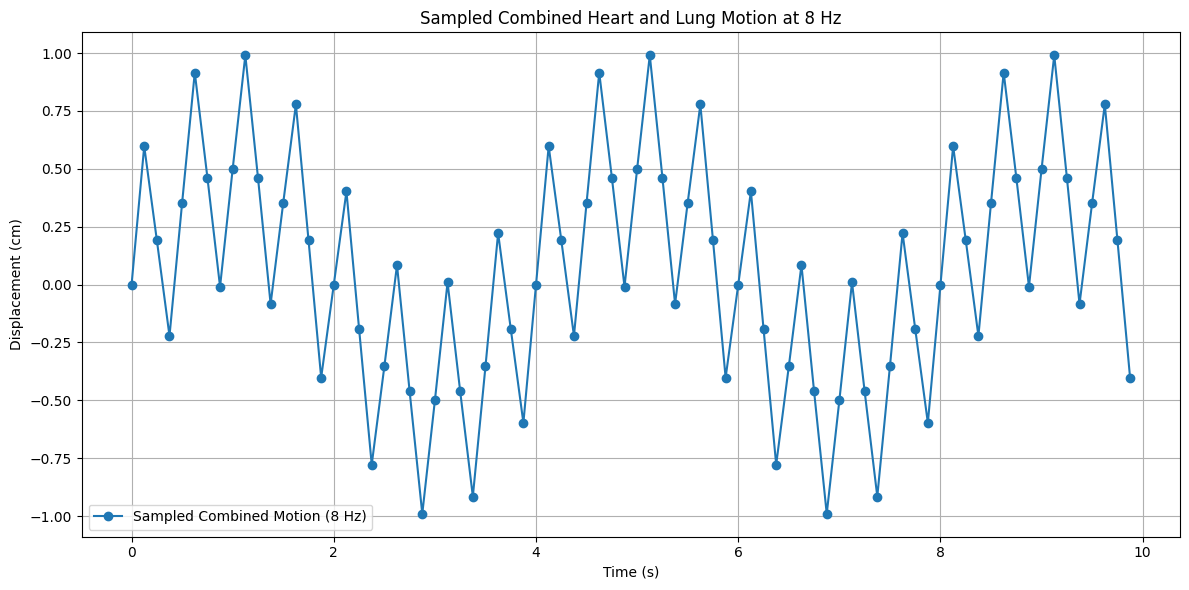

Max step: 83.33333333333333
Non-encoded Motor Steps: [   0  149   48  -56   88  229  115   -2  125  248  115  -21   88  194
   48 -101    0  101  -48 -194  -88   21 -115 -248 -125    2 -115 -229
  -88   56  -48 -149    0  149   48  -56   88  229  115   -2  125  248
  115  -21   88  194   48 -101    0  101  -48 -194  -88   21 -115 -248
 -125    2 -115 -229  -88   56  -48 -149    0  149   48  -56   88  229
  115   -2  125  248  115  -21   88  194   48 -101]
Encoded Motor Instructions: P81001951300381581E517300217D1F81730151581C21300651001650300C20581150730F807D1020730E50581380300951001951300381581E517300217D1F81730151581C21300651001650300C20581150730F807D1020730E50581380300951001951300381581E517300217D1F81730151581C2130065F


In [7]:
# Sampling
heart_motion_sampled, lung_motion_sampled, combined_motion_sampled = generate_motion(t_sampled, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

# Calculate the displacement in mm (combined motion in cm to mm)
combined_motion_sampled_mm = combined_motion_sampled * 10 

# Calculate the number of steps required for each displacement
steps_per_mm = steps_per_revolution / lead_screw_lead 
motor_steps = np.round(combined_motion_sampled_mm * steps_per_mm).astype(int)
motor_instructions = encode_motor_instructions(motor_steps, sampling_rate)

# Plotting for visualization
plt.figure(figsize=(12, 6))
plt.plot(t_sampled, combined_motion_sampled, 'o-', label='Sampled Combined Motion (8 Hz)')
plt.title('Sampled Combined Heart and Lung Motion at 8 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print motor instructions
print(f'Max step: {sampling_interval * steps_per_revolution * motor_speed_rpm / 60}')
print(f'Non-encoded Motor Steps: {motor_steps}')
print(f'Encoded Motor Instructions: {motor_instructions}')
